In [1]:
import os
import glob
import pandas as pd
import dask.dataframe as dd
import numpy as np
import re
import cv2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, SelectFromModel)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
homeFolder = '/content/drive/MyDrive/Colab Notebooks/Sleep/child-mind-institute-detect-sleep-states/'

# Load datasets
train_events = pd.read_csv(homeFolder + 'train_events.csv')
train_series = dd.read_parquet(homeFolder + 'train_series.parquet')
test_series = dd.read_parquet(homeFolder + 'test_series.parquet')

#Preprocessing
train_events.timestamp = pd.to_datetime(train_events['timestamp'], errors='coerce')
train_events.dropna(subset = ['series_id', 'step', 'timestamp'], inplace = True)
train_events.reset_index(drop = True, inplace = True)

train_series.timestamp = dd.to_datetime(train_series['timestamp'], errors='coerce')
train_series = train_series.dropna(subset = ['series_id', 'step', 'timestamp'])
train_series = train_series.reset_index(drop = True)

train_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00-04:00


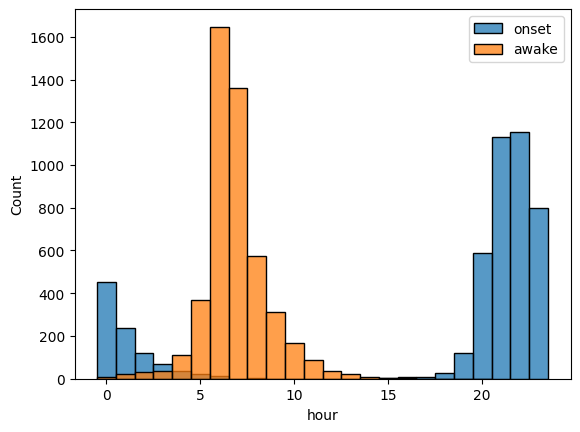

In [11]:
# Filter rows for 'onset' and 'wakeup' events
onset_events = train_events[train_events['event'] == 'onset']
wakeup_events = train_events[train_events['event'] == 'wakeup']

# Extract the hour from 'timestamp' for both events
df_onset = onset_events['timestamp'].apply(lambda x: x.hour)
df_awake = wakeup_events['timestamp'].apply(lambda x: x.hour)

# Create histograms
sns.histplot(df_onset, discrete=True, bins=24, label='onset')
sns.histplot(df_awake, discrete=True, bins=24, label='awake')
plt.legend()
plt.xlabel('hour')
plt.show()

In [13]:
train_series.head().compute()

KeyboardInterrupt: ignored

In [ ]:
bSeries = np.unique(train_events.series_id)

In [ ]:
id_map = bSeries[0]
night_max = 5
# --- events ---
# get one id_map and the dates for 5 nights
df_e = train_events[(train_events["series_id"]==id_map) & (train_events["night"]<=night_max)].reset_index(drop=True)
df_e["date"] = df_e.style.format({"DateTypeCol": lambda t: t.strftime("%Y%m%d")})


# --- series ---
# filter on id_map
df_s = train_series[train_series["series_id"]==id_map].reset_index(drop=True)
df_s["date"] = df_s.style.format({"DateTypeCol": lambda t: t.strftime("%Y%m%d")})
df_s["time"] = df_s.timestamp.dt.time
# now retrieve only 1 day
df_s = df_s[df_s["date"].isin(df_e.date.unique())]

# grab event (target) info
df_s = df_s.merge(right=train_events[["event", "step", "series_id"]],
                  on=["series_id", "step"], how="left")
# fill between 1 and 2 with value 3
# 3 meaning that the person is sleeping
fill_value = 3
where_value = 1
df_s['event'] = df_s['event'].fillna(fill_value).where(df_s['event'].fillna(method='ffill').eq(where_value) | df_s['event'].notna())
